In [0]:
sc

SparkContext 

 Spark UI 

 
 Version 
 v3.3.2 
 Master 
 local[8] 
 AppName 
 Databricks Shell

In [0]:
df = spark.read.csv("/FileStore/tables/Housing.csv", header=True, inferSchema=True) 

In [0]:
df.count()

Out[5]: 545

In [0]:
df.printSchema() 

root
 |-- price: integer (nullable = true)
 |-- area: integer (nullable = true)
 |-- bedrooms: integer (nullable = true)
 |-- bathrooms: integer (nullable = true)
 |-- stories: integer (nullable = true)
 |-- mainroad: string (nullable = true)
 |-- guestroom: string (nullable = true)
 |-- basement: string (nullable = true)
 |-- hotwaterheating: string (nullable = true)
 |-- airconditioning: string (nullable = true)
 |-- parking: integer (nullable = true)
 |-- prefarea: string (nullable = true)
 |-- furnishingstatus: string (nullable = true)



In [0]:
df.createOrReplaceTempView("housing_data") 

In [0]:
%sql 

SELECT bedrooms, COUNT(*) AS count, AVG(price) AS avg_price 

FROM housing_data 

GROUP BY bedrooms 

ORDER BY bedrooms 

bedrooms,count,avg_price
1,2,2712500.0
2,136,3632022.0588235296
3,300,4954598.133333334
4,95,5729757.894736842
5,10,5819800.0
6,2,4791500.0


Data Clean-Up Feature Engineering Spark SQL
Train 80% Test 20%

In [0]:
from pyspark.sql.functions import when
from pyspark.ml.feature import StringIndexer, VectorAssembler 

binary_cols = ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea'] 
for col_name in binary_cols: 
    df = df.withColumn(col_name, when(df[col_name] == 'yes', 1).otherwise(0)) 

indexer = StringIndexer(inputCol="furnishingstatus", outputCol="furnishingstatus_index") 

df = indexer.fit(df).transform(df) 

df = df.dropna() 

In [0]:
feature_cols = ['area', 'bedrooms', 'bathrooms', 'stories', 'mainroad', 'guestroom', 

                'basement', 'hotwaterheating', 'airconditioning', 'parking', 

                'prefarea', 'furnishingstatus_index'] 

  

assembler = VectorAssembler(inputCols=feature_cols, outputCol='features') 

final_df = assembler.transform(df).select('features', 'price') 

In [0]:
train_data, test_data = final_df.randomSplit([0.8, 0.2], seed=42) 

Indluded Four Models: Linear Regression, Decision Tree, Random Forest, Gradient Boosted Trees


In [0]:
from pyspark.ml.regression import LinearRegression, DecisionTreeRegressor, RandomForestRegressor, GBTRegressor  

from pyspark.ml.evaluation import RegressionEvaluator 

models = {
     "Linear Regression": LinearRegression(labelCol="price"), 
     "Decision Tree": 	DecisionTreeRegressor(labelCol="price"), 
     "Random Forest": RandomForestRegressor(labelCol="price"), 
     "Gradient Boosted Trees": GBTRegressor(labelCol="price") 
     } 

evaluator = RegressionEvaluator(labelCol="price", metricName="rmse") 

for name, model in models.items(): 
    print(f"\n{name}") 
    fitted_model = model.fit(train_data) 
    predictions = fitted_model.transform(test_data) 
    rmse = evaluator.evaluate(predictions) 
    print(f"RMSE: {rmse:.2f}") 


Linear Regression
RMSE: 1398475.99

Decision Tree
RMSE: 1423098.88

Random Forest
RMSE: 1464218.48

Gradient Boosted Trees
RMSE: 1539562.79


Linear Regression Lowest RMSE, Therefore, the best model

Linear Regression Model

In [0]:
from pyspark.ml.regression import LinearRegression 

lr = LinearRegression(featuresCol="features", labelCol="price") 

lr_model = lr.fit(train_data) 

In [0]:
lr_predictions = lr_model.transform(test_data) 

lr_predictions.select("features", "price", "prediction").show(5) 

+--------------------+-------+------------------+
|            features|  price|        prediction|
+--------------------+-------+------------------+
|(12,[0,1,2,3],[20...|2660000|3039593.3398224367|
|(12,[0,1,2,3],[22...|3640000|3880720.9696116126|
|(12,[0,1,2,3],[23...|3118850|2820357.2261213227|
|(12,[0,1,2,3],[28...|4620000| 3305871.336197298|
|(12,[0,1,2,3],[30...|4900000| 3553614.328435111|
+--------------------+-------+------------------+
only showing top 5 rows



In [0]:
from pyspark.ml.evaluation import RegressionEvaluator 


evaluator = RegressionEvaluator(labelCol="price", predictionCol="prediction", metricName="rmse") 

rmse = evaluator.evaluate(lr_predictions) 

print(f"Linear Regression RMSE: {rmse:.2f}") 

Linear Regression RMSE: 1398475.99


In [0]:
summary = lr_model.summary  

print("Coefficients:", lr_model.coefficients)  

print("Intercept:", lr_model.intercept)  

print("R²:", summary.r2) 

Coefficients: [306.06666249984,207954.32611283424,1031096.1232110441,549004.9714888851,0.0,0.0,0.0,0.0,0.0,418340.54633572255,0.0,57702.28004670229]
Intercept: -117554.70359172575
R²: 0.5616947295115337


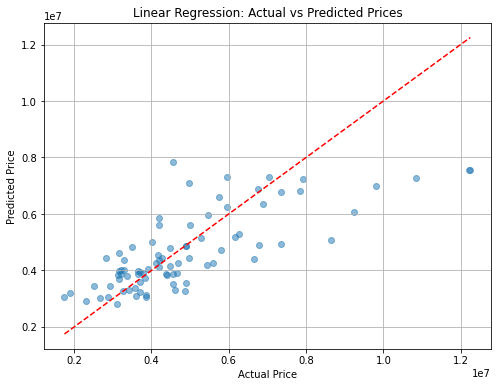

In [0]:
import matplotlib.pyplot as plt 

preds_df = lr_predictions.select("price", "prediction").toPandas() 

plt.figure(figsize=(8,6)) 

plt.scatter(preds_df["price"], preds_df["prediction"], alpha=0.5) 

plt.plot([preds_df["price"].min(), preds_df["price"].max()], 

[preds_df["price"].min(), preds_df["price"].max()], 

color='red', linestyle='--') 

plt.xlabel("Actual Price") 

plt.ylabel("Predicted Price") 

plt.title("Linear Regression: Actual vs Predicted Prices") 

plt.grid(True) 

plt.show() 

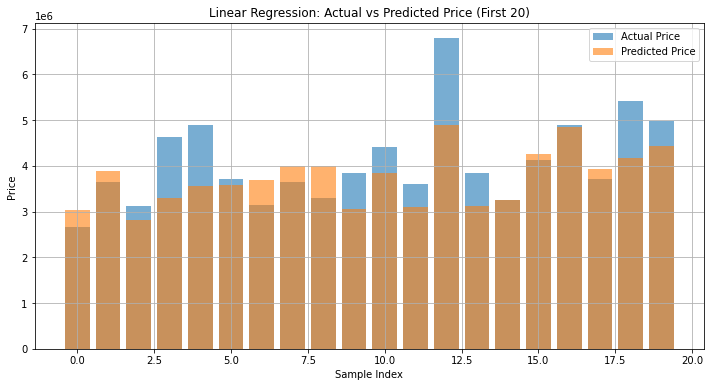

In [0]:
sample_df = preds_df.head(20) 

plt.figure(figsize=(12,6)) 

plt.bar(range(len(sample_df)), sample_df["price"], alpha=0.6, label="Actual Price") 

plt.bar(range(len(sample_df)), sample_df["prediction"], alpha=0.6, label="Predicted Price")  

plt.xlabel("Sample Index") 

plt.ylabel("Price") 

plt.title("Linear Regression: Actual vs Predicted Price (First 20)") 

plt.legend() 

plt.grid(True) 

plt.show() 

 

In [0]:
df.createOrReplaceTempView("housing_data") 

 

In [0]:
ranked_df = spark.sql("""  

SELECT  

area, 

price,  

bedrooms,  

furnishingstatus,  

RANK() OVER (PARTITION BY area ORDER BY price DESC) AS rank_in_area, 

AVG(price) OVER (PARTITION BY area) AS avg_area_price, 

CASE  

WHEN price > AVG(price) OVER (PARTITION BY area) THEN 'Above Average' 

WHEN price < AVG(price) OVER (PARTITION BY area) THEN 'Below Average' 

ELSE 'Average'  

END AS price_position  

FROM housing_data  

""") 

In [0]:
ranked_pd = ranked_df.select("area", "price", "price_position").toPandas() 

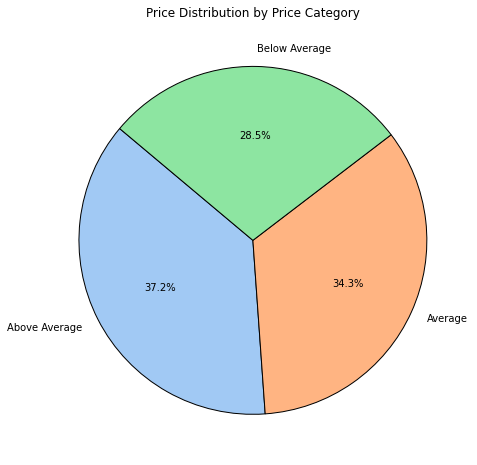

In [0]:
import matplotlib.pyplot as plt
import pandas as pd

if "area" in ranked_pd.columns and "price" in ranked_pd.columns and "price_position" in ranked_pd.columns:
    
    pie_data = ranked_pd.groupby("price_position")["price"].sum()

    plt.figure(figsize=(8, 8))
    plt.pie(
        pie_data, 
        labels=pie_data.index, 
        autopct='%1.1f%%', 
        startangle=140, 
        colors=sns.color_palette("pastel"), 
        wedgeprops={'edgecolor': 'black'}
    )

    plt.title("Price Distribution by Price Category")
    plt.show()

else:
    print("Error: DataFrame 'ranked_pd' is missing required columns.")

In [0]:
ranked_df.write.mode("overwrite").saveAsTable("ranked_housing_data") 

Decsion Tree Model

In [0]:
from pyspark.ml.regression import DecisionTreeRegressor 

dt = DecisionTreeRegressor(featuresCol="features", labelCol="price")
dt_model = dt.fit(train_data) 
dt_predictions = dt_model.transform(test_data) 

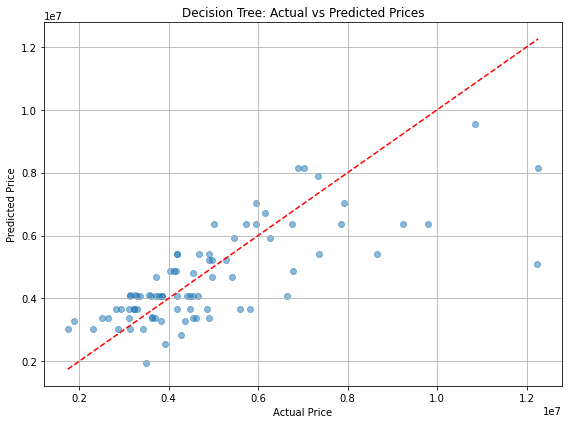

In [0]:
import matplotlib.pyplot as plt  

import pandas as pd 

dt_preds_pd = dt_predictions.select("price", "prediction").toPandas() 

plt.figure(figsize=(8,6)) 

plt.scatter(dt_preds_pd["price"], dt_preds_pd["prediction"], alpha=0.5) 

plt.plot([dt_preds_pd["price"].min(), dt_preds_pd["price"].max()], 

[dt_preds_pd["price"].min(), dt_preds_pd["price"].max()], 

 	color="red", linestyle="--") 

plt.xlabel("Actual Price")  

plt.ylabel("Predicted Price")  

plt.title("Decision Tree: Actual vs Predicted Prices")  

plt.grid(True)  

plt.tight_layout()  

plt.show() 

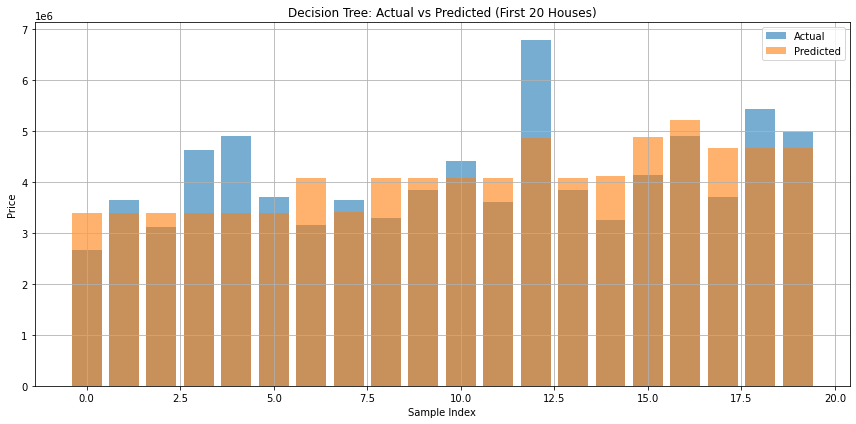

In [0]:
sample_df = dt_preds_pd.head(20) 

plt.figure(figsize=(12,6))  

plt.bar(range(len(sample_df)), sample_df["price"], alpha=0.6, label="Actual")  

plt.bar(range(len(sample_df)), sample_df["prediction"], alpha=0.6, label="Predicted")  

plt.xlabel("Sample Index")  

plt.ylabel("Price")  

plt.title("Decision Tree: Actual vs Predicted (First 20 Houses)")  

plt.legend()  

plt.grid(True)  

plt.tight_layout()  

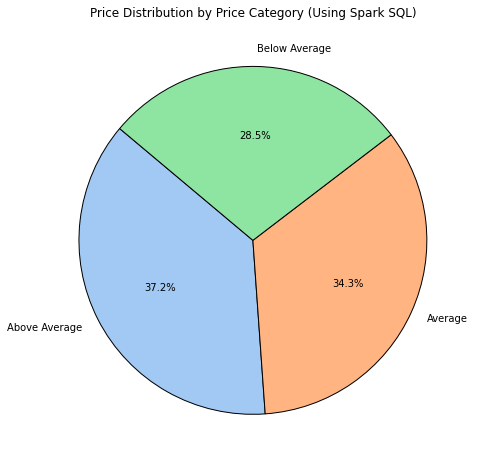

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
 
ranked_pd = ranked_df.select("area", "price", "price_position").toPandas()
 
# Ensure required columns exist
if "area" in ranked_pd.columns and "price" in ranked_pd.columns and "price_position" in ranked_pd.columns:
    # Group and sum prices by price category
    pie_data = ranked_pd.groupby("price_position")["price"].sum()
 
    # Plot pie chart
    plt.figure(figsize=(8, 8))
    plt.pie(
        pie_data,
        labels=pie_data.index,
        autopct='%1.1f%%',
        startangle=140,
        colors=sns.color_palette("pastel"),
        wedgeprops={'edgecolor': 'black'}
    )
    plt.title("Price Distribution by Price Category (Using Spark SQL)")
    plt.show()
 
else:
    print("Error: DataFrame 'ranked_pd' is missing required columns.")

Random Forest Model

In [0]:
from pyspark.ml.regression import RandomForestRegressor
 
rf = RandomForestRegressor(labelCol="price", featuresCol="features", numTrees=100)
rf_model = rf.fit(train_data)
rf_predictions = rf_model.transform(test_data)

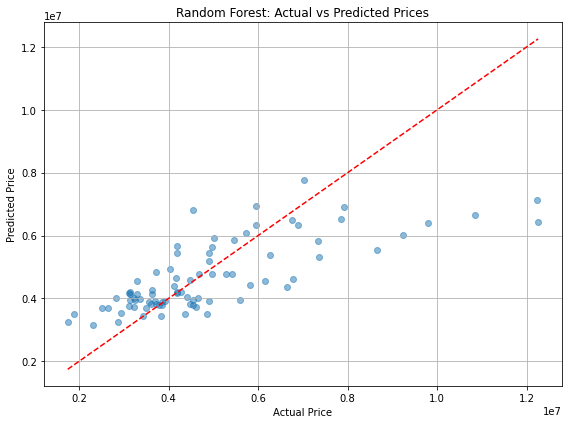

In [0]:
import matplotlib.pyplot as plt
import pandas as pd
 
rf_preds_pd = rf_predictions.select("price", "prediction").toPandas()
 
plt.figure(figsize=(8,6))
plt.scatter(rf_preds_pd["price"], rf_preds_pd["prediction"], alpha=0.5)
plt.plot([rf_preds_pd["price"].min(), rf_preds_pd["price"].max()],
         [rf_preds_pd["price"].min(), rf_preds_pd["price"].max()],
         color="red", linestyle="--")
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Random Forest: Actual vs Predicted Prices")
plt.grid(True)
plt.tight_layout()
plt.show()

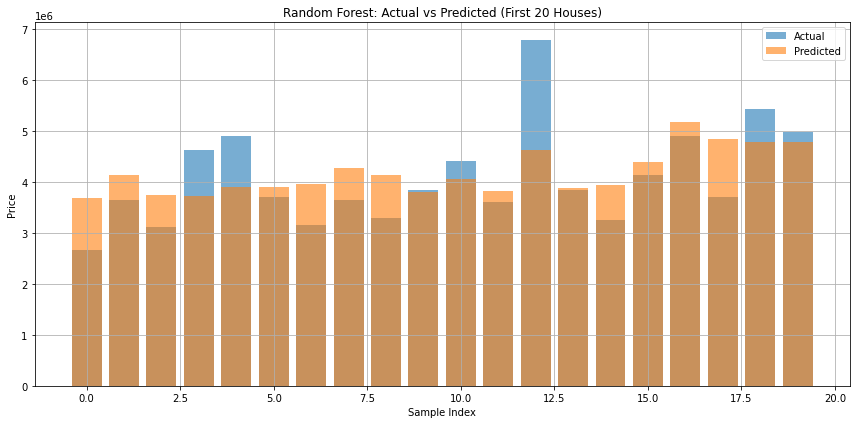

In [0]:
sample_rf_df = rf_preds_pd.head(20)
 
plt.figure(figsize=(12,6))
plt.bar(range(len(sample_rf_df)), sample_rf_df["price"], alpha=0.6, label="Actual")
plt.bar(range(len(sample_rf_df)), sample_rf_df["prediction"], alpha=0.6, label="Predicted")
plt.xlabel("Sample Index")
plt.ylabel("Price")
plt.title("Random Forest: Actual vs Predicted (First 20 Houses)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [0]:
df.createOrReplaceTempView("housing_data")
 
rf_ranked_df = spark.sql("""
    SELECT 
        area,
        price,
        RANK() OVER (PARTITION BY area ORDER BY price DESC) AS rank_in_area,
        AVG(price) OVER (PARTITION BY area) AS avg_area_price,
        CASE 
            WHEN price > AVG(price) OVER (PARTITION BY area) THEN 'Above Average'
            WHEN price < AVG(price) OVER (PARTITION BY area) THEN 'Below Average'
            ELSE 'Average'
        END AS price_position
    FROM housing_data
""")

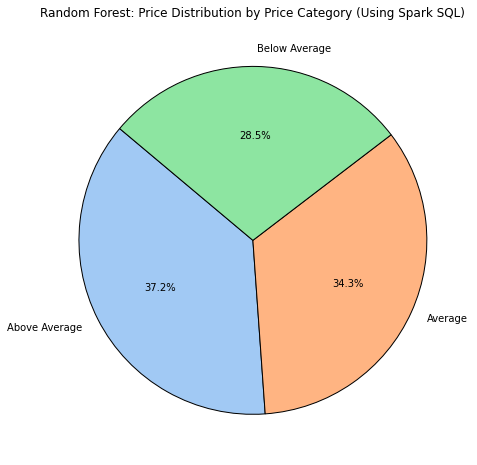

In [0]:
import seaborn as sns
 
rf_ranked_pd = rf_ranked_df.select("area", "price", "price_position").toPandas()
 
if "area" in rf_ranked_pd.columns and "price" in rf_ranked_pd.columns and "price_position" in rf_ranked_pd.columns:
    pie_data = rf_ranked_pd.groupby("price_position")["price"].sum()
 
    plt.figure(figsize=(8, 8))
    plt.pie(
        pie_data,
        labels=pie_data.index,
        autopct='%1.1f%%',
        startangle=140,
        colors=sns.color_palette("pastel"),
        wedgeprops={'edgecolor': 'black'}
    )
    plt.title("Random Forest: Price Distribution by Price Category (Using Spark SQL)")
    plt.show()
else:
    print("Error: DataFrame is missing required columns.")

Gradient Boosted Tree Model

In [0]:
from pyspark.ml.regression import GBTRegressor
 
gbt = GBTRegressor(labelCol="price", featuresCol="features", maxIter=50)
gbt_model = gbt.fit(train_data)
gbt_predictions = gbt_model.transform(test_data)

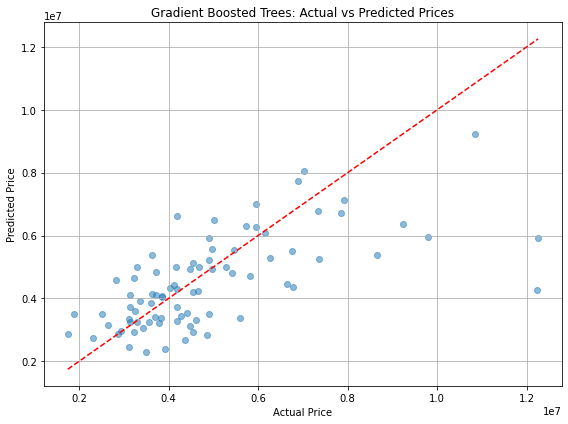

In [0]:
import matplotlib.pyplot as plt
import pandas as pd
 
gbt_preds_pd = gbt_predictions.select("price", "prediction").toPandas()
 
plt.figure(figsize=(8,6))
plt.scatter(gbt_preds_pd["price"], gbt_preds_pd["prediction"], alpha=0.5)
plt.plot([gbt_preds_pd["price"].min(), gbt_preds_pd["price"].max()],
         [gbt_preds_pd["price"].min(), gbt_preds_pd["price"].max()],
         color="red", linestyle="--")
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Gradient Boosted Trees: Actual vs Predicted Prices")
plt.grid(True)
plt.tight_layout()
plt.show()

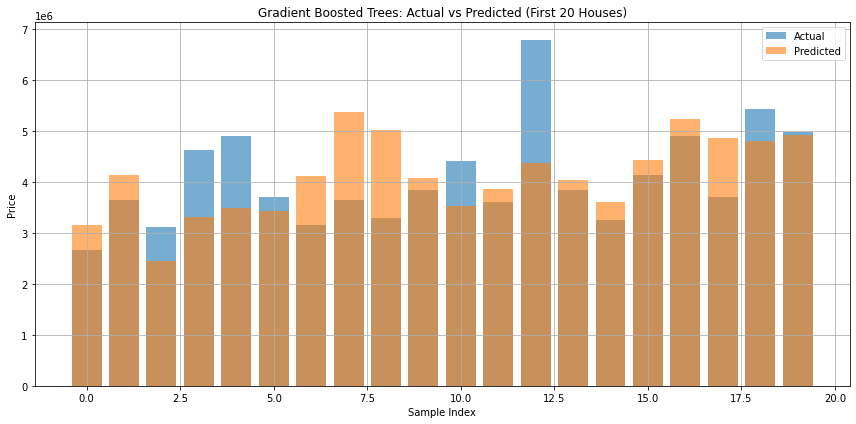

In [0]:
sample_gbt_df = gbt_preds_pd.head(20)
 
plt.figure(figsize=(12,6))
plt.bar(range(len(sample_gbt_df)), sample_gbt_df["price"], alpha=0.6, label="Actual")
plt.bar(range(len(sample_gbt_df)), sample_gbt_df["prediction"], alpha=0.6, label="Predicted")
plt.xlabel("Sample Index")
plt.ylabel("Price")
plt.title("Gradient Boosted Trees: Actual vs Predicted (First 20 Houses)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [0]:
df.createOrReplaceTempView("housing_data")
 
gbt_ranked_df = spark.sql("""
    SELECT 
        area,
        price,
        RANK() OVER (PARTITION BY area ORDER BY price DESC) AS rank_in_area,
        AVG(price) OVER (PARTITION BY area) AS avg_area_price,
        CASE 
            WHEN price > AVG(price) OVER (PARTITION BY area) THEN 'Above Average'
            WHEN price < AVG(price) OVER (PARTITION BY area) THEN 'Below Average'
            ELSE 'Average'
        END AS price_position
    FROM housing_data
""")

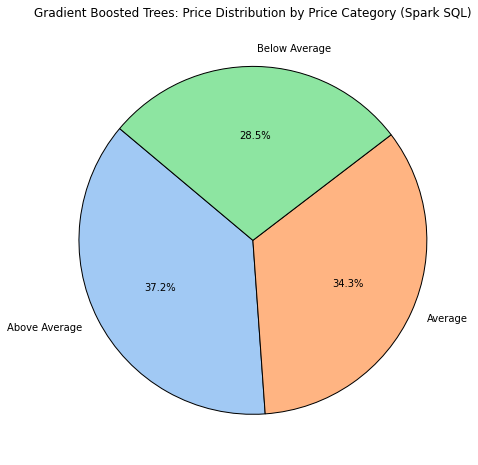

In [0]:
import seaborn as sns
 
gbt_ranked_pd = gbt_ranked_df.select("area", "price", "price_position").toPandas()
 
if "area" in gbt_ranked_pd.columns and "price" in gbt_ranked_pd.columns and "price_position" in gbt_ranked_pd.columns:
    pie_data = gbt_ranked_pd.groupby("price_position")["price"].sum()
 
    plt.figure(figsize=(8, 8))
    plt.pie(
        pie_data,
        labels=pie_data.index,
        autopct='%1.1f%%',
        startangle=140,
        colors=sns.color_palette("pastel"),
        wedgeprops={'edgecolor': 'black'}
    )
    plt.title("Gradient Boosted Trees: Price Distribution by Price Category (Spark SQL)")
    plt.show()
else:
    print("Error: DataFrame is missing required columns.")